In [3]:
# %matplotlib inline
import pandas as pd; pd.options.display.float_format = '{:,.3f}'.format
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (8,6)
import seaborn as sns; sns.set_style("dark")

from pprint import pprint

from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import (
    r2_score, 
    explained_variance_score, 
    mean_absolute_error, 
    mean_squared_error, 
    mean_squared_log_error,
    median_absolute_error
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import copy

Importing the model from github

In [7]:
import os
import pickle

def import_model(model_name):
    with open(model_name, 'rb') as f:
        model = pickle.load(f)
    return model

model = import_model('auction-optimiser-master/output/GradientBoostingClassifier.pkl')

In [10]:
def load_data(filename):
    return pd.read_csv(filename)

def to_category(x):
    if x <= 1:
        return 0
    else:
        return 1

target = "multiplier"
train = load_data("data2014.csv")
test = load_data("data2015.csv")
X_train, y_train = train.drop(target, axis=1), train[target]
X_test, y_test = test.drop(target, axis=1), test[target]

In [11]:
categorical_features = X_train.loc[:, train.nunique() == 2].columns
categorical_indices = [col in categorical_features for col in X_train.columns]

preprocessors = [
#     ("encoder", OneHotEncoder(categorical_features=categorical_indices, sparse=False)),
    ("scaler", StandardScaler(with_mean=False)),
#     ("anova_filter", SelectKBest(score_func=f_regression, k=5)),
#     ("pca", PCA(n_components=10))
#     ("kmeans", KMeans(n_clusters=10))
]

def pipe_fit(preprocessors, X_train, y_train):
    X_train = X_train.copy()
    for name, pp in preprocessors:
        X_train = pp.fit_transform(X_train, y_train)
    return preprocessors, X_train

def pipe_transform(preprocessors, X_test):
    X_test = X_test.copy()
    for name, pp in preprocessors:
        X_test = pp.transform(X_test)
    return X_test

y_train_cat = y_train.map(to_category)
y_test_cat = y_test.map(to_category)
preprocessors, X_train_transformed = pipe_fit(preprocessors, X_train, y_train_cat)
X_test_transformed = pipe_transform(preprocessors, X_test)

In [38]:
#Evaluating test data model prediction probabillities
evaluation = test.loc[test['multiplier'].nsmallest(50).index]
actual = evaluation['multiplier'].values.tolist()
ProbSmalest50 = model.predict_proba(evaluation.drop('multiplier',axis= 1))
PredSmalest50 = model.predict(evaluation.drop('multiplier',axis= 1))
for i in range (len(ProbSmalest50)):
    print('Prediction Probababillity :',
          '{0:.2f} , {1:.2f}'.format(ProbSmalest50[i][0],ProbSmalest50[i][1]),
          PredSmalest50[i],'{0:.2f}'.format(actual[i],),i)
   

Prediction Probababillity : 0.84 , 0.16 0 0.06 0
Prediction Probababillity : 0.98 , 0.02 0 0.10 1
Prediction Probababillity : 0.99 , 0.01 0 0.12 2
Prediction Probababillity : 0.99 , 0.01 0 0.14 3
Prediction Probababillity : 0.98 , 0.02 0 0.14 4
Prediction Probababillity : 0.98 , 0.02 0 0.14 5
Prediction Probababillity : 0.99 , 0.01 0 0.14 6
Prediction Probababillity : 0.98 , 0.02 0 0.15 7
Prediction Probababillity : 0.99 , 0.01 0 0.20 8
Prediction Probababillity : 0.91 , 0.09 0 0.20 9
Prediction Probababillity : 0.98 , 0.02 0 0.23 10
Prediction Probababillity : 0.98 , 0.02 0 0.23 11
Prediction Probababillity : 0.96 , 0.04 0 0.23 12
Prediction Probababillity : 0.97 , 0.03 0 0.23 13
Prediction Probababillity : 0.98 , 0.02 0 0.24 14
Prediction Probababillity : 0.99 , 0.01 0 0.27 15
Prediction Probababillity : 0.98 , 0.02 0 0.30 16
Prediction Probababillity : 0.97 , 0.03 0 0.32 17
Prediction Probababillity : 0.98 , 0.02 0 0.33 18
Prediction Probababillity : 0.98 , 0.02 0 0.33 19
Prediction

Building the optimizer

In [42]:
np.random.seed(42)

def setdaytime(lot):
    "Change auction daytime randomly only one time can be picked at the same time"
    daytime = np.random.randint(0,3)
    lot["Morning"] = int(not bool(daytime))
    lot["Afternoon"] = int(daytime == 1)
    lot["Evening"] = int(daytime == 2)
    return lot

def setauctionduration(lot):
    #Change auction duration
    lot["Duration"] = np.random.randint(50,1001)
    return lot

def setspev(lot):
    #set starting price to estimated price ration
    spev = np.random.random()*1.6 + 0.07
    lot['SP.EV'] = spev
   # print(spev * lot['EstValue'],)
    #because we change the sp.ev we also adapt the startprice
    lot['StartPrice'] = spev * lot['EstValue']
    return lot 

def pickimprovement(lot):
    #pick a random improvement step
    improvementmove = np.random.randint(0,3)
    if improvementmove == 0:
        setdaytime(lot)
    elif improvementmove ==1:
        setauctionduration(lot)
    else:
        setspev(lot)
    
    return lot

def montecarlo(model,lot,iterations):
    
    #initialize to initial parameters to keep track of the changes
    predictionparam = copy.deepcopy(lot.to_frame().transpose())
    #initialize the class probabillity matrix
    predictionprobabillity = np.zeros((iterations+1,2))
    #iterate for iterations steps
    for i in range (iterations):
        
        pickimprovement(lot)
        
        predictionlot = model.predict_proba([lot])
        #add predicted class probabillities to probabillity matrix
        predictionprobabillity[i+1] = predictionlot[0]
        #add new parameter settigs to dataframe
        predictionparam = pd.concat([predictionparam,lot.to_frame().transpose()], axis=0)
        
    #Add predicted class probabillities to dataframe
    predictionparam['PredClass_1']= predictionprobabillity[:,0]
    predictionparam['PredClass_2']=predictionprobabillity[:,1]
    #Reset dataframe index
    predictionparam = predictionparam.reset_index()
    predictionparam = predictionparam.drop(['index'],axis=1)
      
    return predictionprobabillity,predictionparam

In [29]:
test['multiplier'].nsmallest(10)

1327   0.060
4239   0.100
2122   0.117
2475   0.136
2478   0.136
2479   0.136
2397   0.143
2476   0.155
2123   0.200
4119   0.200
Name: multiplier, dtype: float64

In [40]:
lot = copy.deepcopy(test.loc[2397])
resultlot,result_df = montecarlo(model,lot.drop('multiplier'),3000)
resultlot

array([[0.        , 0.        ],
       [0.18884737, 0.81115263],
       [0.23084265, 0.76915735],
       ...,
       [0.94170661, 0.05829339],
       [0.97535903, 0.02464097],
       [0.97535903, 0.02464097]])

In [41]:
result_df[['StartPrice', 'Followers','SP.EV', 'Duration', 'Morning', 'Evening', 'Afternoon', 'PredClass_1',
       'PredClass_2']].loc[result_df['PredClass_2'].nlargest(10).index]

,StartPrice,Followers,SP.EV,Duration,Morning,Evening,Afternoon,PredClass_1,PredClass_2
1651,44.091,3.000,1.260,332.000,0.000,0.000,1.000,0.124,0.876
229,44.889,3.000,1.283,269.000,0.000,0.000,1.000,0.138,0.862
272,44.499,3.000,1.271,145.000,0.000,0.000,1.000,0.146,0.854
1832,43.771,3.000,1.251,162.000,0.000,0.000,1.000,0.146,0.854
1706,43.945,3.000,1.256,259.000,0.000,0.000,1.000,0.146,0.854
755,47.473,3.000,1.356,232.000,0.000,0.000,1.000,0.147,0.853
756,47.473,3.000,1.356,232.000,0.000,0.000,1.000,0.147,0.853
759,47.473,3.000,1.356,210.000,0.000,0.000,1.000,0.147,0.853
1416,47.327,3.000,1.352,232.000,0.000,0.000,1.000,0.147,0.853
2588,43.679,3.000,1.248,319.000,0.000,0.000,1.000,0.148,0.852


In [37]:
model.predict_proba([test.drop(['multiplier'],axis=1).loc[2397]])


array([[0.99169778, 0.00830222]])

In [17]:
test['SP.EV'].nsmallest(10)
test['SP.EV'].nlargest(10)
#test.columns

2482   1.667
2504   1.667
2505   1.667
3971   1.500
3972   1.500
3973   1.500
3974   1.500
2126   1.400
4051   1.350
3978   1.250
Name: SP.EV, dtype: float64

In [18]:
np.random.seed(42)
daytime = np.random.randint(1,4)
Duration = np.random.randint(50,1001)
spev = np.random.random()*1.6 + 0.07


for i in range (0,10):
    daytime = np.random.randint(1,4)
    Duration = np.random.randint(50,1001)
    spev = np.random.random()*1.6 + 0.07
    print(daytime,Duration,spev)

3 121 1.0278535747152586
3 171 0.31959123253792426
3 508 1.4558818332398964
3 711 0.16025852644336042
2 855 0.07124602534562294
1 210 0.5567875887352605
2 302 0.7611120298273852
1 524 1.0489646315558072
2 525 1.628008830146335
3 239 0.2149702952525133


In [174]:
np.random.seed(42)

def setdaytime(lot):
    "Change auction daytime randomly only one time can be picked at the same time"
    daytime = np.random.randint(0,3)
    lot["Morning"] = int(not bool(daytime))
    lot["Afternoon"] = int(daytime == 1)
    lot["Evening"] = int(daytime == 2)
    return lot

def setauctionduration(lot):
    
    lot["Duration"] = np.random.randint(50,1001)
    return lot

def setspev(lot):
    spev = np.random.random()*1.6 + 0.07
    lot['SP.EV'] = spev
   # print(spev * lot['EstValue'],)
    lot['StartPrice'] = spev * lot['EstValue']
    return lot 

def pickimprovement(lot):
    improvementmove = np.random.randint(0,3)
    if improvementmove == 0:
        setdaytime(lot)
    elif improvementmove ==1:
        setauctionduration(lot)
    else:
        setspev(lot)
    
    return lot

def montecarlo(model,lot,iterations):
    daytime = np.random.randint(0,3)
    predictionparam = copy.deepcopy(lot.to_frame().transpose())
    
    
    predictionprobabillity = np.zeros((iterations+1,2))
    
    for i in range (iterations):
        pickimprovement(lot)
        predictionlot = model.predict_proba([lot])
        predictionprobabillity[i+1] = predictionlot[0]
        
        predictionparam = pd.concat([predictionparam,lot.to_frame().transpose()], axis=0)
        
    
    predictionparam['PredClass_1']= predictionprobabillity[:,0]
    predictionparam['PredClass_2']=predictionprobabillity[:,1]

    predictionparam = predictionparam.reset_index()
    predictionparam = predictionparam.drop(['index'],axis=1)
    #predictionparam = predictionparam.drop(['level_0'],axis=1)   
    return predictionprobabillity,predictionparam
    

In [20]:
model.feature_importances_

array([2.81126062e-01, 9.68709093e-05, 8.68173137e-02, 7.76622247e-02,
       2.24568443e-01, 3.27057452e-03, 4.93914709e-03, 9.78905210e-04,
       3.36786853e-03, 5.04338543e-02, 8.96749673e-02, 5.37216738e-03,
       7.48928103e-02, 8.57338397e-02, 1.10855223e-03, 4.02606827e-03,
       5.93033000e-03])

In [21]:
test.columns


Index(['multiplier', 'LotNr', 'Allocate', 'EstValue', 'StartPrice',
       'Followers', 'Bank', 'Dealer', 'Liquidator', 'Volunteer', 'LotsSale',
       'LotsCtgry', 'Forced', 'SP.EV', 'Duration', 'Morning', 'Evening',
       'Afternoon'],
      dtype='object')

In [81]:
a=np.zeros((10,2))
a[1]=[1,2]
a

array([[0., 0.],
       [1., 2.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [175]:
import copy
lot = copy.deepcopy(test.loc[1327])
resultlot,result_df = montecarlo(model,lot.drop('multiplier'),100)
resultlot

array([[0.        , 0.        ],
       [0.92593173, 0.07406827],
       [0.30254857, 0.69745143],
       [0.30254857, 0.69745143],
       [0.50799556, 0.49200444],
       [0.94072779, 0.05927221],
       [0.94072779, 0.05927221],
       [0.94999903, 0.05000097],
       [0.94389128, 0.05610872],
       [0.94072779, 0.05927221],
       [0.90480053, 0.09519947],
       [0.89906911, 0.10093089],
       [0.90242187, 0.09757813],
       [0.90242187, 0.09757813],
       [0.90798239, 0.09201761],
       [0.92055113, 0.07944887],
       [0.84273463, 0.15726537],
       [0.27645522, 0.72354478],
       [0.21003734, 0.78996266],
       [0.21003734, 0.78996266],
       [0.21003734, 0.78996266],
       [0.91030059, 0.08969941],
       [0.86260079, 0.13739921],
       [0.79176799, 0.20823201],
       [0.77625503, 0.22374497],
       [0.77625503, 0.22374497],
       [0.84048328, 0.15951672],
       [0.38517929, 0.61482071],
       [0.40593903, 0.59406097],
       [0.36856609, 0.63143391],
       [0.

In [176]:
result_df

,LotNr,Allocate,EstValue,StartPrice,Followers,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,SP.EV,Duration,Morning,Evening,Afternoon,PredClass_1,PredClass_2
0,"1,026.000",0.000,500.000,30.000,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,0.060,364.000,0.000,0.000,1.000,0.000,0.000
1,"1,026.000",0.000,500.000,30.000,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,0.060,364.000,0.000,1.000,0.000,0.926,0.074
2,"1,026.000",0.000,500.000,658.753,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,1.318,364.000,0.000,1.000,0.000,0.303,0.697
3,"1,026.000",0.000,500.000,658.753,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,1.318,364.000,0.000,1.000,0.000,0.303,0.697
4,"1,026.000",0.000,500.000,658.753,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,1.318,516.000,0.000,1.000,0.000,0.508,0.492
5,"1,026.000",0.000,500.000,81.467,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,0.163,516.000,0.000,1.000,0.000,0.941,0.059
6,"1,026.000",0.000,500.000,81.467,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,0.163,516.000,0.000,1.000,0.000,0.941,0.059
7,"1,026.000",0.000,500.000,81.467,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,0.163,358.000,0.000,1.000,0.000,0.950,0.050
8,"1,026.000",0.000,500.000,81.467,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,0.163,393.000,0.000,1.000,0.000,0.944,0.056
9,"1,026.000",0.000,500.000,81.467,7.000,0.000,1.000,0.000,0.000,"1,053.000",29.000,0.000,0.163,855.000,0.000,1.000,0.000,0.941,0.059


In [164]:
result_df['PredClass_1']= resultlot[:,0]
result_df['PredClass_2']=resultlot[:,1]

result_df = result_df.reset_index()
result_df = result_df.drop(['index'],axis=1)
result_df = result_df.drop(['level_0'],axis=1)
result_df

,Afternoon,Allocate,Bank,Dealer,Duration,EstValue,Evening,Followers,Forced,Liquidator,LotNr,LotsCtgry,LotsSale,Morning,SP.EV,StartPrice,Volunteer,PredClass_1,PredClass_2
0,1.000,0.000,0.000,1.000,364.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,0.060,30.000,0.000,0.000,0.000
1,1.000,0.000,0.000,1.000,364.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,0.060,30.000,0.000,0.842,0.158
2,1.000,0.000,0.000,1.000,302.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,0.060,30.000,0.000,0.862,0.138
3,0.000,0.000,0.000,1.000,302.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",1.000,0.060,30.000,0.000,0.919,0.081
4,0.000,0.000,0.000,1.000,302.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",1.000,1.049,524.482,0.000,0.334,0.666
5,0.000,0.000,0.000,1.000,525.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",1.000,1.049,524.482,0.000,0.586,0.414
6,0.000,0.000,0.000,1.000,525.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",1.000,0.800,399.856,0.000,0.827,0.173
7,0.000,0.000,0.000,1.000,525.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",1.000,1.059,529.709,0.000,0.586,0.414
8,0.000,0.000,0.000,1.000,525.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",1.000,1.643,821.585,0.000,0.445,0.555
9,0.000,0.000,0.000,1.000,525.000,500.000,1.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,1.643,821.585,0.000,0.440,0.560


In [165]:
result_df.loc[result_df['PredClass_2'].nlargest(5).index]

,Afternoon,Allocate,Bank,Dealer,Duration,EstValue,Evening,Followers,Forced,Liquidator,LotNr,LotsCtgry,LotsSale,Morning,SP.EV,StartPrice,Volunteer,PredClass_1,PredClass_2
166,1.000,0.000,0.000,1.000,337.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,1.654,827.043,0.000,0.089,0.911
726,1.000,0.000,0.000,1.000,249.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,1.650,825.134,0.000,0.123,0.877
728,1.000,0.000,0.000,1.000,249.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,1.669,834.483,0.000,0.123,0.877
895,1.000,0.000,0.000,1.000,248.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,1.345,672.438,0.000,0.124,0.876
702,1.000,0.000,0.000,1.000,250.000,500.000,0.000,7.000,0.000,0.000,"1,026.000",29.000,"1,053.000",0.000,1.025,512.474,0.000,0.127,0.873


In [65]:
test_df = test.loc[1]
test_df1 = test.loc[2]
test_df3 = test.loc[2:4]
#print(test_df.to_frame(),test_df1)
#test_df3 = pd.DataFrame(dict(s1 = test_df, s2 = test_df1)).reset_index()
#test_df3 = test_df.merge(pd.DataFrame(data = [test_df1.values] * len(s), columns = test_df1.index), left_index=True, right_index=True)
#print(test_df3)
test_df = pd.concat([test_df3,test_df1.to_frame().transpose()], axis=0)
#test_df.transpose()
test_df

,multiplier,LotNr,Allocate,EstValue,StartPrice,Followers,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,SP.EV,Duration,Morning,Evening,Afternoon
2,0.960,3.000,0.000,"1,250.000",750.000,24.000,0.000,1.000,0.000,0.000,646.000,38.000,0.000,0.600,338.000,0.000,0.000,1.000
3,1.071,4.000,0.000,"1,750.000","1,275.000",14.000,0.000,1.000,0.000,0.000,646.000,38.000,0.000,0.729,338.000,0.000,0.000,1.000
4,3.333,5.000,0.000,750.000,500.000,43.000,0.000,1.000,0.000,0.000,646.000,38.000,0.000,0.667,338.000,0.000,0.000,1.000
2,0.960,3.000,0.000,"1,250.000",750.000,24.000,0.000,1.000,0.000,0.000,646.000,38.000,0.000,0.600,338.000,0.000,0.000,1.000


In [25]:
for result in resultlot:
    print(type(result[0][1]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

In [26]:
resultlot[0][0][1]

0.07406827188904631

In [27]:
setauctionduration(lot)
lot

multiplier       0.060
LotNr        1,026.000
Allocate         0.000
EstValue       500.000
StartPrice      30.000
Followers        7.000
Bank             0.000
Dealer           1.000
Liquidator       0.000
Volunteer        0.000
LotsSale     1,053.000
LotsCtgry       29.000
Forced           0.000
SP.EV            0.060
Duration       498.000
Morning          0.000
Evening          0.000
Afternoon        1.000
Name: 1327, dtype: float64

In [28]:
for i in range (0,100):
    setauctionduration(lot)
    print(lot['Duration'])

473.0
509.0
725.0
350.0
968.0
352.0
336.0
444.0
59.0
756.0
679.0
319.0
641.0
654.0
827.0
893.0
911.0
410.0
306.0
182.0
325.0
825.0
732.0
562.0
362.0
625.0
935.0
333.0
170.0
156.0
982.0
736.0
253.0
214.0
354.0
546.0
681.0
605.0
873.0
205.0
416.0
768.0
951.0
669.0
300.0
965.0
931.0
383.0
691.0
560.0
342.0
69.0
331.0
846.0
50.0
168.0
84.0
247.0
534.0
806.0
108.0
886.0
210.0
740.0
255.0
61.0
539.0
325.0
742.0
291.0
265.0
300.0
860.0
175.0
266.0
355.0
846.0
234.0
88.0
272.0
233.0
544.0
476.0
227.0
968.0
477.0
343.0
901.0
200.0
433.0
687.0
862.0
357.0
385.0
995.0
795.0
941.0
424.0
57.0
390.0


### Data Preparation

In [13]:
import os
os.listdir()

['.ipynb_checkpoints',
 'Anaconda3-5.1.0-Windows-x86_64.exe',
 'auction-optimiser-master',
 'auction-optimiser-master.zip',
 'data2014.csv',
 'data2015.csv',
 'Decision Trees.ipynb',
 'Descriptive Agis.ipynb',
 'Descriptive analysis .ipynb',
 'Human Resource Predictive Analysis - Updated.ipynb',
 'Option valuation Black-Scholes for JADS course.xlsx',
 'Predictive analysis.ipynb',
 'untitled.png',
 'visualisation (1).py',
 'visualisation.py',
 '__pycache__']

In [14]:
import pickle

def import_model(model_name):
    with open(model_name, 'rb') as f:
        model = pickle.load(f)
    return model

model = import_model('auction-optimiser-master/output/GradientBoostingClassifier.pkl')

In [15]:
model.feature_importances_


array([2.81126062e-01, 9.68709093e-05, 8.68173137e-02, 7.76622247e-02,
       2.24568443e-01, 3.27057452e-03, 4.93914709e-03, 9.78905210e-04,
       3.36786853e-03, 5.04338543e-02, 8.96749673e-02, 5.37216738e-03,
       7.48928103e-02, 8.57338397e-02, 1.10855223e-03, 4.02606827e-03,
       5.93033000e-03])

In [10]:
evaluation1 = test.loc[test['multiplier'].nlargest(50).index]
ProbLargest50 = model.predict_proba(evaluation1.drop('multiplier',axis= 1))
PredLargest50 = model.predict(evaluation1.drop('multiplier',axis= 1))
for i in range (len(PredLargest50)):
    print('Prediction Probababillity :',ProbLargest50[i],PredLargest50[i])
    

NameError: name 'test' is not defined

In [11]:
evaluation = test.loc[test['multiplier'].nsmallest(50).index]
actual = evaluation['multiplier'].values.tolist()
ProbSmalest50 = model.predict_proba(evaluation.drop('multiplier',axis= 1))
PredSmalest50 = model.predict(evaluation.drop('multiplier',axis= 1))
for i in range (len(ProbSmalest50)):
    print('Prediction Probababillity :',
          '{0:.2f} , {1:.2f}'.format(ProbSmalest50[i][0],ProbSmalest50[i][1]),
          PredSmalest50[i],'{0:.2f}'.format(actual[i],),i)
   

NameError: name 'test' is not defined

In [23]:
model.decision_function

<bound method GradientBoostingClassifier.decision_function of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=11,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)>

In [55]:
model.feature_importances_

array([2.81126062e-01, 9.68709093e-05, 8.68173137e-02, 7.76622247e-02,
       2.24568443e-01, 3.27057452e-03, 4.93914709e-03, 9.78905210e-04,
       3.36786853e-03, 5.04338543e-02, 8.96749673e-02, 5.37216738e-03,
       7.48928103e-02, 8.57338397e-02, 1.10855223e-03, 4.02606827e-03,
       5.93033000e-03])

In [44]:
ProbSmalest50[0][1]

0.158086884287773

In [22]:
evaluation


,multiplier,LotNr,Allocate,EstValue,StartPrice,Followers,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,SP.EV,Duration,Morning,Evening,Afternoon
1327,0.060,1026,0,500,30,7,0,1,0,0,1053,29,0,0.060,364,0,0,1
4239,0.100,210,0,20,1,19,1,0,0,0,280,139,1,0.050,334,1,0,0
2122,0.117,583,0,120,10,4,0,1,0,0,1329,630,0,0.083,63,0,0,1
2475,0.136,1028,0,110,15,20,0,1,0,0,1329,630,0,0.136,63,0,0,1
2478,0.136,1031,0,110,15,15,0,1,0,0,1329,630,0,0.136,63,0,0,1
2479,0.136,1032,0,110,15,15,0,1,0,0,1329,630,0,0.136,63,0,0,1
2397,0.143,941,0,35,5,3,0,1,0,0,1329,630,0,0.143,65,0,0,1
2476,0.155,1029,0,110,15,17,0,1,0,0,1329,630,0,0.136,63,0,0,1
2123,0.200,584,0,50,10,3,0,1,0,0,1329,630,0,0.200,63,0,0,1
4119,0.200,38,0,100,10,25,1,0,0,0,280,59,1,0.100,334,1,0,0


In [12]:
def load_data(filename):
    return pd.read_csv(filename)

def to_category(x):
    if x <= 1:
        return 0
    else:
        return 1

target = "multiplier"
train = load_data("data2014.csv")
test = load_data("data2015.csv")
X_train, y_train = train.drop(target, axis=1), train[target]
X_test, y_test = test.drop(target, axis=1), test[target]

### Preprocessing

Prepare data for classification

In [17]:
categorical_features = X_train.loc[:, train.nunique() == 2].columns
categorical_indices = [col in categorical_features for col in X_train.columns]

preprocessors = [
#     ("encoder", OneHotEncoder(categorical_features=categorical_indices, sparse=False)),
    ("scaler", StandardScaler(with_mean=False)),
#     ("anova_filter", SelectKBest(score_func=f_regression, k=5)),
#     ("pca", PCA(n_components=10))
#     ("kmeans", KMeans(n_clusters=10))
]

def pipe_fit(preprocessors, X_train, y_train):
    X_train = X_train.copy()
    for name, pp in preprocessors:
        X_train = pp.fit_transform(X_train, y_train)
    return preprocessors, X_train

def pipe_transform(preprocessors, X_test):
    X_test = X_test.copy()
    for name, pp in preprocessors:
        X_test = pp.transform(X_test)
    return X_test

y_train_cat = y_train.map(to_category)
y_test_cat = y_test.map(to_category)
preprocessors, X_train_transformed = pipe_fit(preprocessors, X_train, y_train_cat)
X_test_transformed = pipe_transform(preprocessors, X_test)

### Classification

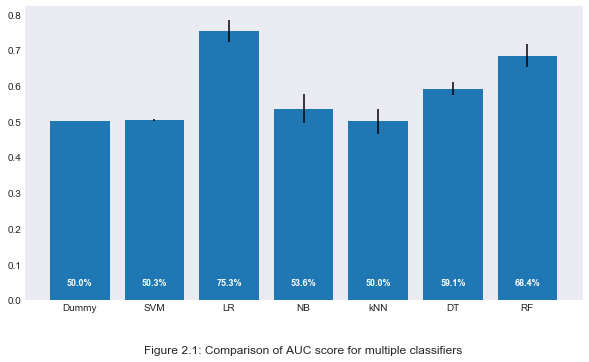

In [4]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
from visualisation import label_barchart

scoring = "roc_auc"

models = [
    
    ("Dummy", DummyClassifier(strategy="most_frequent")),
    ("SVM", SVC()), 
    ("LR", LogisticRegression()),
    ("NB", GaussianNB()),
    ("kNN", KNeighborsClassifier()),
    ("DT", DecisionTreeClassifier()), 
    ("RF", RandomForestClassifier())

]

results = OrderedDict()
for name, model in models:
    kfold = KFold(n_splits=3)
    cv_results = cross_val_score(model, X_train, y_train_cat, cv=kfold, scoring=scoring)
    results[name] = cv_results
    
results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.bar(range(results.shape[1]), results.mean(), yerr=results.std())
plt.gca().set_xticklabels([""] + list(results.columns) + [""])
plt.title("Figure 2.1: Comparison of AUC score for multiple classifiers", y=-.2)
plt.subplots_adjust(bottom=.2)
label_barchart(plt.gca())


In [5]:
n_features = X_train_transformed.shape[1]

classifiers = [
    ("LogisticRegression", LogisticRegression()), 
    ("RandomForest", RandomForestClassifier(n_estimators=50)),
    ("DT", DecisionTreeClassifier())
]

all_params = {
    "LogisticRegression": {"penalty": ["l1", "l2"], "C": np.logspace(-3, 3, 7), "class_weight":["balanced", None]}, 
    "RandomForest": {
        "max_features": range(5, n_features, (n_features - 5) // 3), 
        "max_depth": range(3, 6, 2),
        "min_samples_split": range(5, 101, 25)
    },
    "DT": {
        "max_depth": range(3, 6, 2),
        "min_samples_split": range(5, 101, 25),
    },
}
results = pd.DataFrame(index=[item[0] for item in classifiers], 
                       columns=["name", "params", "accuracy", "auc_score_tr", "auc_score_te", 
                                "precision", "recall", "fscore", "support", "TP", "FP", "FN", "TN"])


best_models, scores = [], []
for i, ((name, clf)) in enumerate(classifiers):
    params = all_params[name]
    gs = GridSearchCV(clf, params, n_jobs=-1, return_train_score=True).fit(X_train_transformed, y_train_cat)
    best_models.append(gs.best_estimator_)
    y_pred = gs.predict(X_test_transformed)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test_cat, y_pred)
    auc_score_te = roc_auc_score(y_test_cat, y_pred)
    auc_score_tr = gs.best_score_
    accuracy = (y_pred == y_test_cat).mean()
    params = gs.best_params_
    [[TP, FN], [FP, TN]] = confusion_matrix(y_test_cat, y_pred)
    results.loc[name, :] = (name, params, accuracy, auc_score_tr, auc_score_te, precision, 
                            recall, fscore, support, TP, FP, FN, TN)
    
    scores.append(roc_auc_score(y_test_cat, y_pred))
    gs_results = pd.DataFrame(gs.cv_results_).drop("params", axis=1).sort_values("rank_test_score")
    print("\n{}:\n".format(name))
    print("\tAccuracy: {:.2%}".format((y_pred == y_test_cat).mean()))
    print("\tAUC Score (Train set): {:.2%}".format(gs.best_score_))
    print("\tAUC Score (Test set): {:.2%}\n".format(scores[-1]))
    print(classification_report(y_test_cat, y_pred))
    print(best_models[-1], "\n")
    if i + 1 < len(classifiers): print("#" * 100)
    
#results



LogisticRegression:

	Accuracy: 70.69%
	AUC Score (Train set): 68.77%
	AUC Score (Test set): 68.14%

             precision    recall  f1-score   support

          0       0.71      0.84      0.77      2555
          1       0.71      0.52      0.60      1860

avg / total       0.71      0.71      0.70      4415

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 

####################################################################################################

RandomForest:

	Accuracy: 70.65%
	AUC Score (Train set): 70.70%
	AUC Score (Test set): 68.91%

             precision    recall  f1-score   support

          0       0.72      0.80      0.76      2555
          1       0.68      0.58      0.62      1860

avg / total       0.70      0.71      0.70      4415

R

In [6]:
dt = best_models[-1]

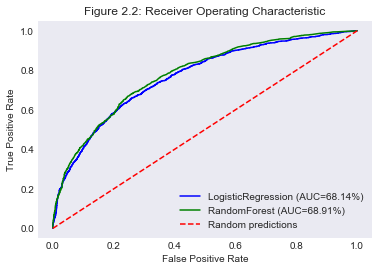

In [7]:
lr_scores = best_models[0].predict_proba(X_test_transformed)[:, 1]
rf_scores = best_models[1].predict_proba(X_test_transformed)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test_cat.ravel(), lr_scores.ravel())
rf_fpr, rf_tpr, _ = roc_curve(y_test_cat.ravel(), rf_scores.ravel())
plt.plot(lr_fpr, lr_tpr, 'b', label='LogisticRegression (AUC={:.2%})'.format(scores[0]))
plt.plot(rf_fpr, rf_tpr, 'g', label='RandomForest (AUC={:.2%})'.format(scores[1]))
plt.title('Figure 2.2: Receiver Operating Characteristic')
plt.plot([0,1],[0,1],'r--', label="Random predictions")
plt.legend(loc=4)
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate');

In [8]:
clf = best_models[0]
coef = pd.DataFrame(index=X_train.columns)
coef["Coefficients"] = clf.coef_[0]
coef.sort_values("Coefficients", ascending=False)

,Coefficients
Followers,1.506
StartPrice,0.892
Forced,0.717
SP.EV,0.497
LotNr,0.082
LotsCtgry,0.080
Allocate,-0.135
Evening,-0.149
Morning,-0.226
Afternoon,-0.287


In [9]:
# sns.pairplot(train.loc[:, train.nunique() != 2])
# plt.savefig("pairplot.png")

In [10]:
# # Confidence Threshold
# alpha = .1

# np.random.seed(42)  # To make sure our results are reproducible
# anova_filter = SelectKBest()
# anova_filter.fit(X_train, y_train)


# anova_scores = pd.DataFrame(index=X_train.columns)
# anova_scores["Fisher"] = anova_filter.scores_
# anova_scores["p-value"] = anova_filter.pvalues_
# anova_scores = anova_scores.sort_values("Fisher", ascending=False)
# # selected_features = list(anova_scores.loc[anova_scores["p-value"] < 1 - alpha, :].index)
# # if len(selected_features) == X_train.shape[1]:
# #     print("No discarded feature")
# # X = X[selected_features]
# anova_scores.style.apply(lambda f: ["color: red"] * 2 if f["p-value"] > 1-alpha else ["color: black"]*2, axis=1)

In [11]:
.mean()

SyntaxError: invalid syntax (<ipython-input-11-fbf3e4c57138>, line 1)

In [12]:
print(best_models)

[LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=13, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=55,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=No

In [13]:
roc_auc_score(dt.predict(X_test), y_test_cat)

0.6886304487493602

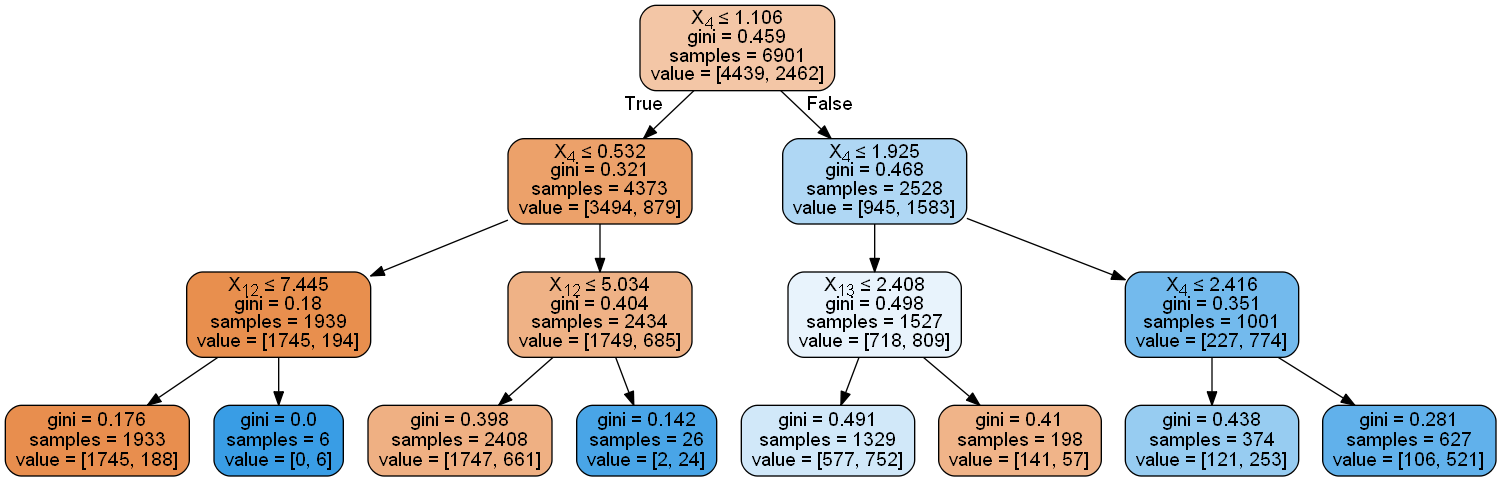

In [14]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [15]:
rf = best_models[1]
pd.DataFrame(rf.feature_importances_, index=X_train.columns).sort_values(0, ascending=False)

,0
Followers,0.889
Duration,0.037
LotsSale,0.028
SP.EV,0.019
EstValue,0.012
StartPrice,0.006
Forced,0.003
LotsCtgry,0.003
LotNr,0.002
Liquidator,0.001


In [49]:
dt
test['multiplier'].nsmallest(50)


multiplier       0.060
LotNr        1,026.000
Allocate         0.000
EstValue       500.000
StartPrice      30.000
Followers        7.000
Bank             0.000
Dealer           1.000
Liquidator       0.000
Volunteer        0.000
LotsSale     1,053.000
LotsCtgry       29.000
Forced           0.000
SP.EV            0.060
Duration       364.000
Morning          0.000
Evening          0.000
Afternoon        1.000
Name: 1327, dtype: float64

In [18]:
evaluation = test.loc[test['multiplier'].nsmallest(50).index]
evaluation

,multiplier,LotNr,Allocate,EstValue,StartPrice,Followers,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,SP.EV,Duration,Morning,Evening,Afternoon
1327,0.060,1026,0,500,30,7,0,1,0,0,1053,29,0,0.060,364,0,0,1
4239,0.100,210,0,20,1,19,1,0,0,0,280,139,1,0.050,334,1,0,0
2122,0.117,583,0,120,10,4,0,1,0,0,1329,630,0,0.083,63,0,0,1
2475,0.136,1028,0,110,15,20,0,1,0,0,1329,630,0,0.136,63,0,0,1
2478,0.136,1031,0,110,15,15,0,1,0,0,1329,630,0,0.136,63,0,0,1
2479,0.136,1032,0,110,15,15,0,1,0,0,1329,630,0,0.136,63,0,0,1
2397,0.143,941,0,35,5,3,0,1,0,0,1329,630,0,0.143,65,0,0,1
2476,0.155,1029,0,110,15,17,0,1,0,0,1329,630,0,0.136,63,0,0,1
2123,0.200,584,0,50,10,3,0,1,0,0,1329,630,0,0.200,63,0,0,1
4119,0.200,38,0,100,10,25,1,0,0,0,280,59,1,0.100,334,1,0,0


Creating a brute force approach to optimization. There are 3 decision variables we can essentially optimize 
1. Starting Price
2. Duration
3. Time of Day
Our brute force approach is for a given auction in the test set to find which decision variable setting will have the best result according to our prediction model 
For Our first experiment we will take a bad performing auction and try to determine the decision variable setting which results in the best prediction. It is important to note here that we would prefer a clasifier model which outputs the classification probabillity so we can fine tune it as well

For our first example we select auction 22 which has a multiplier rate of 0.6 which is quite low

In [37]:
AuctionToOptimize = test.loc[11].values
print(AuctionToOptimize)

[  3.58333333  12.           0.         600.         400.
  44.           0.           1.           0.           0.
 646.          38.           0.           0.66666667 338.
   0.           0.           1.        ]


In [63]:
result = dt.predict(evaluation.drop('multiplier',axis= 1))
result

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1], dtype=int64)

In [60]:
evaluation.drop('multiplier',axis= 1)


,LotNr,Allocate,EstValue,StartPrice,Followers,Bank,Dealer,Liquidator,Volunteer,LotsSale,LotsCtgry,Forced,SP.EV,Duration,Morning,Evening,Afternoon
1327,1026,0,500,30,7,0,1,0,0,1053,29,0,0.060,364,0,0,1
4239,210,0,20,1,19,1,0,0,0,280,139,1,0.050,334,1,0,0
2122,583,0,120,10,4,0,1,0,0,1329,630,0,0.083,63,0,0,1
2475,1028,0,110,15,20,0,1,0,0,1329,630,0,0.136,63,0,0,1
2478,1031,0,110,15,15,0,1,0,0,1329,630,0,0.136,63,0,0,1
2479,1032,0,110,15,15,0,1,0,0,1329,630,0,0.136,63,0,0,1
2397,941,0,35,5,3,0,1,0,0,1329,630,0,0.143,65,0,0,1
2476,1029,0,110,15,17,0,1,0,0,1329,630,0,0.136,63,0,0,1
2123,584,0,50,10,3,0,1,0,0,1329,630,0,0.200,63,0,0,1
4119,38,0,100,10,25,1,0,0,0,280,59,1,0.100,334,1,0,0
